In [1]:
!git clone https://github.com/ricklentz/PartSLIP.git

Cloning into 'PartSLIP'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 73 (delta 16), reused 59 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (73/73), 21.77 MiB | 10.69 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [ ]:
!pip install "git+https://github.com/facebookresearch/pytorch3d.git"

  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-hw8m14he
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-hw8m14he
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 64a5bfadc8948ee921b36fe4044343dc9270ba40
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 837.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.4/904.4 kB 64.5 MB/s eta 0:00:00


In [ ]:
import os
os.chdir("PartSLIP")

In [ ]:
import torch
import json
from pytorch3d.io import IO
import numpy as np
from PartSLIP.src.utils import normalize_pc
from PartSLIP.src.render_pc import render_pc

def render(input_pc_file, category, part_names, zero_shot=False, save_dir="tmp"):

    print("[creating tmp dir...]")
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cpu")
    io = IO()
    os.makedirs(save_dir, exist_ok=True)

    print("[normalizing input point cloud...]")
    xyz, rgb = normalize_pc(input_pc_file, save_dir, io, device)

    print(rgb)
    print("[rendering input point cloud...]")
    img_dir, pc_idx, screen_coords = render_pc(xyz, rgb, save_dir, device)

partnete_meta = json.load(open("PartNetE_meta.json"))
for ins in ["Chair", "Suitcase", "Refrigerator", "Lamp", "Kettle"]:
    render('examples/%s.ply' % ins, ins, partnete_meta[ins], zero_shot=True, save_dir='examples/zeroshot_%s' % ins)



[creating tmp dir...]
[normalizing input point cloud...]
[[    0.40784     0.40784     0.40392]
 [    0.41569     0.41569     0.41569]
 [    0.42353     0.42353     0.42353]
 ...
 [    0.55686     0.55686     0.55686]
 [    0.54902     0.54902     0.54902]
 [    0.51765     0.51765     0.51765]]
[rendering input point cloud...]
[creating tmp dir...]
[normalizing input point cloud...]
[[    0.73333     0.73333     0.73333]
 [    0.77647     0.77647     0.77647]
 [    0.77255     0.77255     0.77255]
 ...
 [    0.46667     0.46667     0.46667]
 [    0.46667     0.46667     0.46667]
 [    0.41961     0.41961     0.41961]]
[rendering input point cloud...]
[creating tmp dir...]
[normalizing input point cloud...]
[[        0.8         0.8     0.79608]
 [    0.82745     0.82745     0.82745]
 [    0.82353     0.82353     0.82353]
 ...
 [    0.87451     0.87451     0.87451]
 [    0.88235     0.88235     0.88235]
 [    0.83529     0.83529     0.83529]]
[rendering input point cloud...]
[creating 


image 1/1 /content/PartSLIP/examples/zeroshot_Chair/rendered_img/2.png: 640x640 1 chair legs, 19.7ms
Speed: 3.4ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


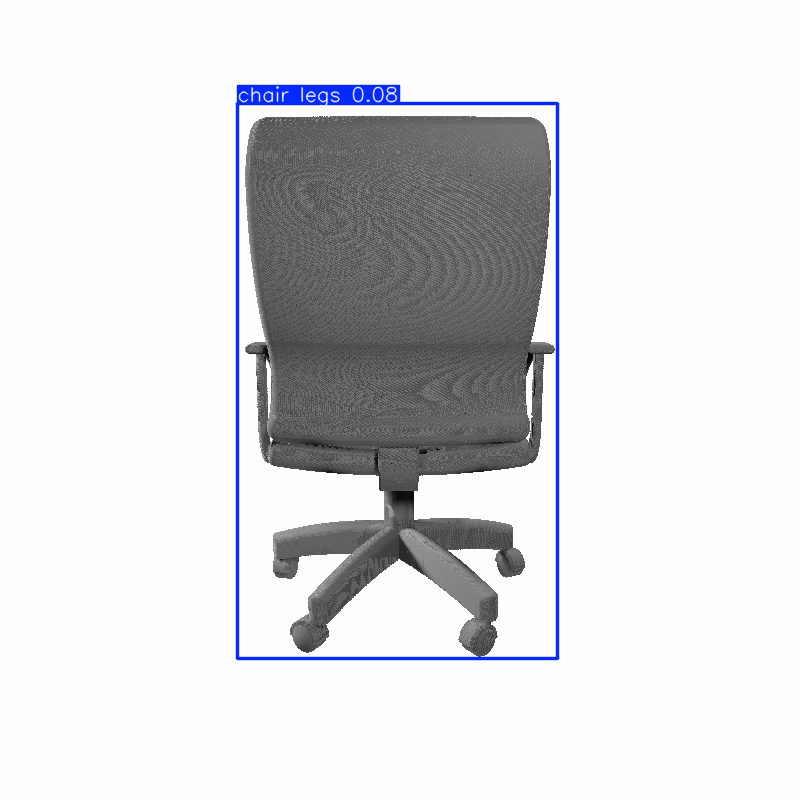

In [ ]:
# https://docs.ultralytics.com/reference/models/yolo/world/train/
from ultralytics import YOLOWorld

# Initialize a YOLO-World model
model = YOLOWorld("yolov8s-world.pt")  # or select yolov8m/l-world.pt for different sizes

model.set_classes(["chair legs"])

# Execute inference with the YOLOv8s-world model on the specified image
results = model.predict("examples/zeroshot_Chair/rendered_img/2.png", conf = 0.05)

# Show results
results[0].show()

In [ ]:
xyxy = results[0].boxes.xyxy

# https://docs.ultralytics.com/reference/models/sam/predict/

from ultralytics import SAM

# Load a model
model = SAM("sam_b.pt")

# Display model information (optional)
model.info()

# Run inference with bboxes prompt
results_full = model("examples/zeroshot_Chair/rendered_img/2.png", bboxes=xyxy)

100%|██████████| 358M/358M [00:24<00:00, 15.6MB/s]


Model summary: 243 layers, 93,735,472 parameters, 93,735,472 gradients

image 1/1 /content/PartSLIP/examples/zeroshot_Chair/rendered_img/2.png: 1024x1024 1 0, 511.3ms
Speed: 6.3ms preprocess, 511.3ms inference, 10.5ms postprocess per image at shape (1, 3, 1024, 1024)


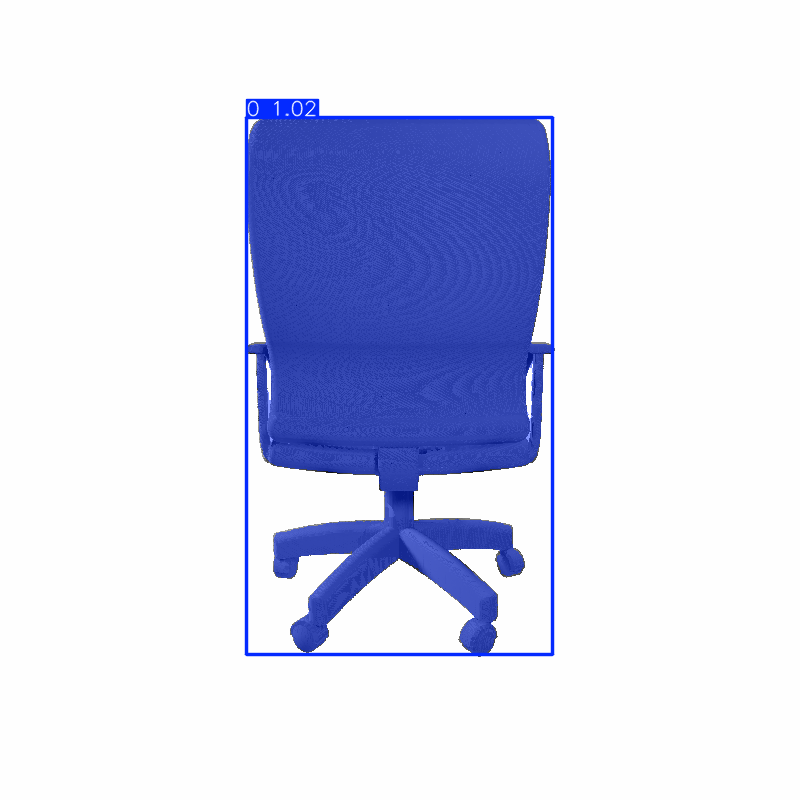

In [ ]:
results_full[0].show()

In [ ]:
!pip install opencv-python

In [ ]:
# Get the cropped image
import cv2
img = cv2.imread("examples/zeroshot_Chair/rendered_img/2.png")

# Extract bounding boxes
boxes = results[0].boxes.xyxy.tolist()

# Iterate through the bounding boxes
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    # Crop the object using the bounding box coordinates
    ultralytics_crop_object = img[int(y1):int(y2), int(x1):int(x2)]
    # Save the cropped object as an image
    cv2.imwrite('crop_' + str(i) + '.jpg', ultralytics_crop_object)


image 1/1 /content/PartSLIP/crop_0.jpg: 640x384 2 chair backs, 14.0ms
Speed: 1.7ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


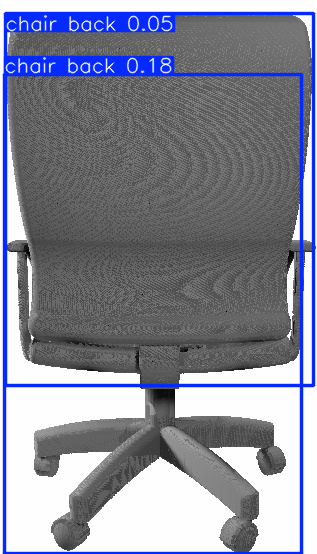

In [ ]:
# Detect parts

from ultralytics import YOLOWorld

# Initialize a YOLO-World model
model = YOLOWorld("yolov8s-world.pt")  # or select yolov8m/l-world.pt for different sizes

model.set_classes(["chair back"])

# Execute inference with the YOLOv8s-world model on the specified image
results_parts = model.predict("crop_0.jpg", conf = 0.05)

results_parts[0].show()